# Plotting electric field lines of point charges

Code taken and adapted from
https://www.numbercrunch.de/blog/2013/05/visualizing-streamlines/
and
https://pythonmatplotlibtips.blogspot.com/2017/12/draw-continuous-electric-field-lines-3d-plotly.html

## Using `streamplot`

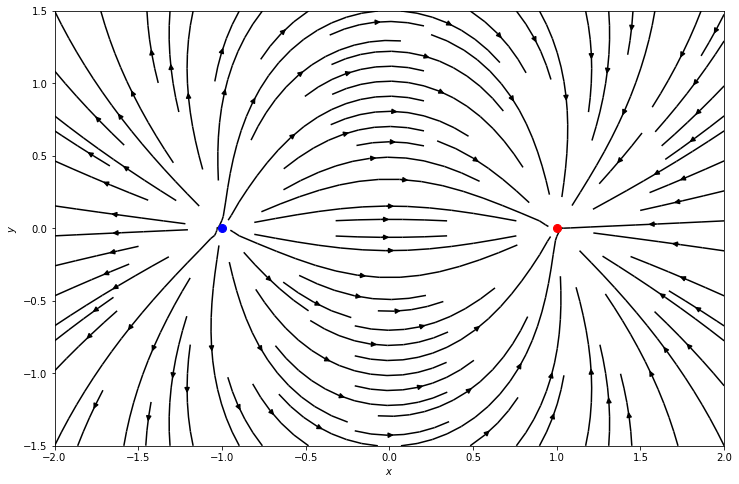

In [1]:
#!/usr/bin/env python
 
# import useful modules
import matplotlib 
from numpy import *
from pylab import *
from scipy.integrate import ode

%matplotlib inline
 
class charge:
    def __init__(self, q, pos):
        self.q=q
        self.pos=pos
 
def E_point_charge(q, a, x, y):
    return q*(x-a[0])/((x-a[0])**2+(y-a[1])**2)**(1.5), \
        q*(y-a[1])/((x-a[0])**2+(y-a[1])**2)**(1.5)
 
def E_total(x, y, charges):
    Ex, Ey=0, 0
    for C in charges:
        E=E_point_charge(C.q, C.pos, x, y)
        Ex=Ex+E[0]
        Ey=Ey+E[1]
    return [ Ex, Ey ]
 
close('all')
figure(figsize=(12, 8))
 
# charges and positions
charges=[ charge(1, [-1, 0]), charge(-1, [1, 0]) ]
 
# plot field lines
x0, x1=-2, 2
y0, y1=-1.5, 1.5
x=linspace(x0, x1, 64)
y=linspace(y0, y1, 64)
x, y=meshgrid(x, y)
Ex, Ey=E_total(x, y, charges)
streamplot(x, y, Ex, Ey, color='k')
 
# plot point charges
for C in charges:
    if C.q>0:
        plot(C.pos[0], C.pos[1], 'bo', ms=8*sqrt(C.q))
    if C.q<0:
        plot(C.pos[0], C.pos[1], 'ro', ms=8*sqrt(-C.q))
 
xlabel('$x$')
ylabel('$y$')
gca().set_xlim(x0, x1)
gca().set_ylim(y0, y1)
show()

### Solving the field line ODEs

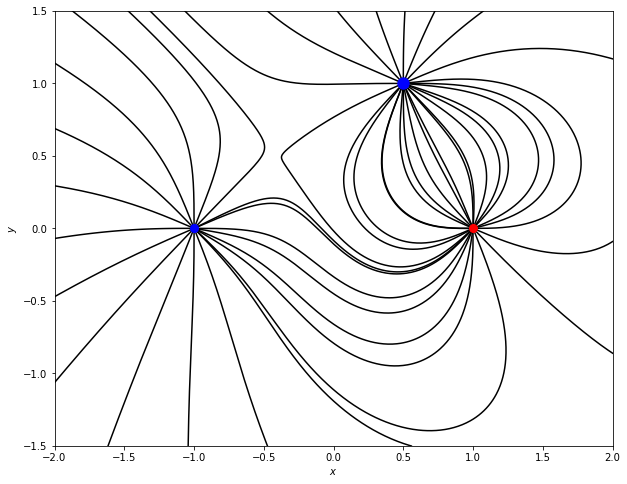

In [2]:
#!/usr/bin/env python
 
# import useful modules
import matplotlib 
from numpy import *
from pylab import *
from scipy.integrate import ode

%matplotlib inline
 
class charge:
    def __init__(self, q, pos):
        self.q=q
        self.pos=pos
 
def E_point_charge(q, a, x, y):
    return q*(x-a[0])/((x-a[0])**2+(y-a[1])**2)**(1.5), \
        q*(y-a[1])/((x-a[0])**2+(y-a[1])**2)**(1.5)
 
def E_total(x, y, charges):
    Ex, Ey=0, 0
    for C in charges:
        E=E_point_charge(C.q, C.pos, x, y)
        Ex=Ex+E[0]
        Ey=Ey+E[1]
    return [ Ex, Ey ]

def E_dir(t, y, charges):
    Ex, Ey=E_total(y[0], y[1], charges)
    n=sqrt(Ex**2+Ey*Ey)
    return [Ex/n, Ey/n]
 
close('all')
figure(figsize=(10, 8))
 
# charges and positions
charges=[ charge(1, [-1, 0]), charge(-1, [1, 0]), charge(2, [0.5,1])]
 
# plot field lines
x0, x1=-2, 2
y0, y1=-1.5, 1.5
R=0.01
# loop over all charges
for C in charges:
    # plot field lines starting in current charge
    dt=0.8*R
    if C.q<0:
        dt=-dt
    # loop over field lines starting in different directions 
    # around current charge
    for alpha in linspace(0, 2*pi*15/16, 16):
        r=ode(E_dir)
        r.set_integrator('vode')
        r.set_f_params(charges)
        x=[ C.pos[0] + cos(alpha)*R ]
        y=[ C.pos[1] + sin(alpha)*R ]
        r.set_initial_value([x[0], y[0]], 0)
        while r.successful():
            r.integrate(r.t+dt)
            x.append(r.y[0])
            y.append(r.y[1])
            hit_charge=False
            # check if field line left drawing area or ends in some charge
            for C2 in charges:
                if sqrt((r.y[0]-C2.pos[0])**2+(r.y[1]-C2.pos[1])**2)<R:
                    hit_charge=True
            if hit_charge or (not (x0<r.y[0] and r.y[0]<x1)) or \
                    (not (y0<r.y[1] and r.y[1]<y1)):
                break
        plot(x, y, '-k')
 
# plot point charges
for C in charges:
    if C.q>0:
        plot(C.pos[0], C.pos[1], 'bo', ms=8*sqrt(C.q))
    if C.q<0:
        plot(C.pos[0], C.pos[1], 'ro', ms=8*sqrt(-C.q))
 
xlabel('$x$')
ylabel('$y$')
gca().set_xlim(x0, x1)
gca().set_ylim(y0, y1)
show()

### Creating 3D plots with `plotly`

In [3]:
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
from itertools import product
from matplotlib import cm
from scipy.integrate import ode as ode

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

class charge:
    def __init__(self, q, pos):
        self.q=q
        self.pos=pos
 
def E_point_charge(q, a, x, y, z):
    deno = ((x-a[0])**2+(y-a[1])**2+(z-a[2])**2)**(1.5)
    return q*(x-a[0])/deno, q*(y-a[1])/deno, q*(z-a[2])/deno
 
def E_total(x, y, z, charges):
    Ex, Ey, Ez = 0, 0, 0
    for C in charges:
        E = E_point_charge(C.q, C.pos, x, y, z)
        Ex = Ex+E[0]
        Ey = Ey+E[1]
        Ez = Ez+E[2]
    return [ Ex, Ey, Ez ]

def E_dir(t, p, charges):
    Ex, Ey, Ez = E_total(p[0], p[1], p[2], charges)
    n = np.sqrt(Ex**2+Ey**2+Ez**2)
    return [Ex/n, Ey/n, Ez/n]

def V_point_charge(q, p, x, y, z):
    deno = np.sqrt((x-p[0])**2+(y-p[1])**2+(z-p[2])**2)
    return q/deno

def V_total(x, y, z, charges):
    V = 0
    for C in charges:
        Vp = V_point_charge(C.q, C.pos, x, y, z)
        V = V+Vp
    return V

# charges and positions
charges=[ charge(-1, [-1, 0,0]), charge(1, [1, 0,0]) ]
 
# calculate field lines
x0, x1 = -2, 2
y0, y1 = -2, 2
z0, z1 = -2, 2

R = 0.3
# loop over all charges
xs, ys, zs = [], [], []
for C in charges:
    # calculate field lines starting in current charge
    dt = 0.8*R
    if C.q < 0:
        dt = -dt
    # loop over field lines starting in different directions 
    # around current charge
    for alpha,beta in product(np.linspace(0, 2*np.pi*11/12, 12),np.linspace(0, 2*np.pi*11/12, 12)):
        r=ode(E_dir)
        r.set_integrator('vode')
        r.set_f_params(charges)
        # initial position of the electric field line
        x=[ C.pos[0] + np.cos(alpha)*np.cos(beta)*R ]
        y=[ C.pos[1] + np.sin(alpha)*np.cos(beta)*R ]
        z=[ C.pos[2] + np.sin(beta)*R ]
        r.set_initial_value([x[0], y[0], z[0]], 0)
        while r.successful():
            r.integrate(r.t+dt)
            x.append(r.y[0])
            y.append(r.y[1])
            z.append(r.y[2])
            hit_charge = False
            # check if field line left drwaing area or ends in some charge
            for C2 in charges:
                dist = np.sqrt((r.y[0]-C2.pos[0])**2+(r.y[1]-C2.pos[1])**2+(r.y[2]-C2.pos[2])**2)
                if dist < R:
                    hit_charge=True
            if hit_charge or (not (x0<r.y[0] and r.y[0]<x1)) or \
                    (not (y0<r.y[1] and r.y[1]<y1)) or (not (z0<r.y[2] and r.y[2]<z1)):
                break
        xs.append(x)
        ys.append(y)
        zs.append(z)

# Stock the field lines as plotly scatter3d data
data = []
for x, y, z in zip(xs,ys,zs):
    trace = go.Scatter3d(
        x=x, y=y, z=z,
        line=dict(color='#000000'),
        mode="lines",
        name="",
        showlegend=False,
    )
    data.append(trace)

# Then draw the slice of the electric field.

# colormap of the electric field
# here, the cm.jet is used
cmfunc = lambda x: 255*cm.jet(x)
pl_BrBG = [ [x, "rgb(%d,%d,%d)"%(255*cmfunc(x)[0],255*cmfunc(x)[1],255*cmfunc(x)[2])] 
           for x in np.linspace(0,1,11) ]

def get_the_slice(x,y,z, surfacecolor,  colorscale=pl_BrBG, showscale=False):
    return go.Surface(x=x,# https://plot.ly/python/reference/#surface
                   y=y,
                   z=z,
                   surfacecolor=surfacecolor,
                   colorscale=colorscale,
                   showscale=showscale,
                   name="")

def get_lims_colors(surfacecolor):# color limits for a slice
    return np.min(surfacecolor), np.max(surfacecolor)

# The sliced surface in the x,y plane
x = np.linspace(-2,2, 20)
y = np.linspace(-2,2, 20)
x,y = np.meshgrid(x,y)
z = np.zeros(x.shape)

surfcolor_z = V_total(x,y,z,charges)
slice_z = get_the_slice(x,y,z, surfcolor_z)

# The sliced surface in the x,z plane
x=np.linspace(-2,2, 20)
z=np.linspace(-2,2, 20)
x,z=np.meshgrid(x,y)

y=np.zeros(x.shape)

surfcolor_y = V_total(x,y,z,charges)
slice_y = get_the_slice(x,y,z, surfcolor_y)

vmin,vmax = -3,3
slice_z.update(cmin=vmin, cmax=vmax)
slice_y.update(cmin=vmin, cmax=vmax, showscale=True,
               colorbar=go.ColorBar(title='Potential [a.u.]'),)

data.append(slice_z)
data.append(slice_y)

axis = dict(showbackground=True, 
            backgroundcolor="rgb(230, 230,230)",
            gridcolor="rgb(255, 255, 255)",      
            zerolinecolor="rgb(255, 255, 255)",  
            )

layout = go.Layout(
         width=700,
         height=700,
         scene=go.Scene(xaxis=go.XAxis(axis),
                        yaxis=go.YAxis(axis), 
                        zaxis=go.ZAxis(axis, range=[-2,2]), 
                        aspectratio=dict(x=1, y=1, z=1),
                        ),
        )

# Plot the data
fig = dict(data=data,layout=layout)
py.iplot(fig)

C:\Users\fbar\Programming\WPy64-3820\python-3.8.2.amd64\lib\site-packages\plotly\graph_objs\_deprecations.py:173: DeprecationWarning:

plotly.graph_objs.ColorBar is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.marker.ColorBar
  - plotly.graph_objs.surface.ColorBar
  - etc.


C:\Users\fbar\Programming\WPy64-3820\python-3.8.2.amd64\lib\site-packages\plotly\graph_objs\_deprecations.py:544: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


C:\Users\fbar\Programming\WPy64-3820\python-3.8.2.amd64\lib\site-packages\plotly\graph_objs\_deprecations.py:572: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


C:\Users\fbar\Programming\WPy64